<a href="https://colab.research.google.com/github/SERVIR/RX_fires/blob/main/EIA/TEV_Script_Final_Tim_Dev_9_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Original method broken into individual cells

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [2]:
# Set a random seed for reproducibility
np.random.seed(42)

## TEV Calculation Function
# This function calculates the Total Economic Value (TEV) for a given set of parameters.
# It's designed to handle both single values (for known data) and distributions (for Monte Carlo).

def calculate_tev(case_params, total_acres, num_simulations=1):
    """
    Calculates the Total Economic Value (TEV) for a given set of parameters.

    Args:
        case_params (dict): A dictionary containing all parameters for the TEV calculation.
                            Values can be single floats/ints or tuples (mean, std_dev) for distributions.
        total_acres (float): The total acreage for the case study region. If 0 or None, TEV per acre is returned.
        num_simulations (int): Number of Monte Carlo simulations to run.
                               If 1, it calculates TEV for the mean/single values.

    Returns:
        numpy.ndarray: An array of TEV values (total or per acre), one for each simulation.
    """

    simulated_tevs_per_acre = np.zeros(num_simulations)

    # Helper function to get a value: either directly or from a normal distribution
    def get_value(param):
        if isinstance(param, tuple):  # Assume (mean, std_dev) for normal distribution
            return np.random.normal(param[0], param[1])
        return param

    for i in range(num_simulations):
        # Timber Value (PV(t)) per acre
        # P(t) = E[Pt] + epsilon(t)
        E_Pt = get_value(case_params['E_Pt'])
        epsilon_t = get_value(case_params.get('epsilon_t', 0)) # Default to 0 if not specified
        P_actual_t = E_Pt + epsilon_t

        V_t = get_value(case_params['V_t'])
        g = get_value(case_params['g'])
        pv_timber_per_acre = P_actual_t * V_t - g

        # Carbon Benefits (pvc) per acre
        # Using the new interpretation: direct pvc_per_acre from input data
        pvc_per_acre_val = get_value(case_params['pvc_per_acre'])

        # Ecosystem Services (PE) per acre
        # w(t) now has two components
        water_quality_value = get_value(case_params['water_quality_value'])
        endangered_species_WTP = get_value(case_params['endangered_species_WTP'])

        pe_per_acre = water_quality_value + endangered_species_WTP

        # Land Value for Hunting/Leases (L) per acre
        R_t_lease = case_params['R_t_lease'] # This should be a list/array of annual revenues per acre
        T_lease = case_params['T_lease']
        r_lease = get_value(case_params['r_lease'])

        l_per_acre = 0
        for t_val in range(1, T_lease + 1):
            current_R = R_t_lease[t_val-1] if t_val-1 < len(R_t_lease) else 0
            l_per_acre += current_R / ((1 + r_lease)**t_val)

        # Total Economic Value (TEV) per acre
        simulated_tevs_per_acre[i] = pv_timber_per_acre + pvc_per_acre_val + pe_per_acre + l_per_acre

    # Scale by total_acres if provided
    if total_acres is not None and total_acres > 0:
        return simulated_tevs_per_acre * total_acres
    else:
        return simulated_tevs_per_acre # Returns TEV per acre

Adapting From: https://github.com/SERVIR/RX_fires/blob/main/OBIWAN_Rx_Fire_Dev.ipynb

In [ ]:
# import pandas as pd

# # Create the dataframe
# data = {
#     "Source": ["EIA_CS1", "EIA_CS2", "EIA_CS3", "EIA_CS1", "EIA_CS2", "EIA_CS3"],
#     "agb_per_acre": [81.444949, 80.442362, 68.891332, 78.533213, 68.227288, 65.785482],
#     "std_agb_per_acre": [1.060591, 1.229071, 1.160256, 0.055407, 0.021973, 0.082459],
#     "Method": ["OBIWAN", "OBIWAN", "OBIWAN", "ESA", "ESA", "ESA"]
# }

# df = pd.DataFrame(data)

# # Display the dataframe
# print(df)


    Source  agb_per_acre  std_agb_per_acre  Method
0  EIA_CS1     81.444949          1.060591  OBIWAN
1  EIA_CS2     80.442362          1.229071  OBIWAN
2  EIA_CS3     68.891332          1.160256  OBIWAN
3  EIA_CS1     78.533213          0.055407     ESA
4  EIA_CS2     68.227288          0.021973     ESA
5  EIA_CS3     65.785482          0.082459     ESA


In [ ]:
# # Case Definitions with New Data

# # Case 1: Wildfire in a region with NO prescribed burn (Oakmulgee WMA, 1068.732 acres)
# case1_params = {
#     'E_Pt': (7.50, 1),      # Stumpage price for salvaged pulpwood-quality timber ($/ton)
#     'V_t': (81.44949,1.060591),#(10, 2),         # Remaining timber stock (tons/acre) - very low
#     'g': (375, 50),         # Regeneration cost ($/acre) - full cost
#     'pvc_per_acre': (-100, 20), # Carbon loss ($/acre)
#     # Ecosystem Valuation: Water Quality (dummy) + RCW WTP
#     'water_quality_value': (5, 1), # Dummy low for severe wildfire
#     'endangered_species_WTP': (13.37 * 0.1, 1), # RCW WTP, significantly reduced due to severe impact
#     'R_t_lease': [50, 20, 0, 0, 0], # Lease revenues ($/acre/year) - severely impacted
#     'T_lease': 5,
#     'r_carbon': 0.05,
#     'r_ecosystem': 0.05,
#     'r_lease': 0.06 # Higher risk
# }
# case1_acres = 1068.732

# # Case 2: Wildfire in a region WITH prescribed burn (Oakmulgee WMA, 636.125 acres)
# case2_params = {
#     'E_Pt': (21, 3),        # Stumpage price for mixed chip-n-saw quality timber ($/ton)
#     'V_t':  (80.442366,1.229071),        # Remaining timber stock (tons/acre) - moderate
#     'g': (200, 30),         # Regeneration cost ($/acre) - partial
#     'pvc_per_acre': (-50, 10), # Carbon loss ($/acre) - mitigated
#     # Ecosystem Valuation: Water Quality (dummy) + RCW WTP
#     'water_quality_value': (20, 3), # Dummy moderate for mitigated wildfire
#     'endangered_species_WTP': (13.37 * 0.5, 2), # RCW WTP, partially retained
#     'R_t_lease': [200, 100, 50, 20, 10], # Lease revenues ($/acre/year) - less impacted
#     'T_lease': 5,
#     'r_carbon': 0.05,
#     'r_ecosystem': 0.05,
#     'r_lease': 0.055 # Moderate risk
# }
# case2_acres = 636.125

# # Case 3: Prescribed burn in LLP ecosystem (NO wildfire) (Same region as Case 2, 616.865 acres)
# case3_params = {
#     'E_Pt': (36, 5),        # Stumpage price for high-value timber ($/ton)
#     'V_t': (68.891332,1.160256),        # Healthy timber stock (tons/acre)
#     'g': (50, 10),          # Regeneration cost ($/acre) - minimal (e.g., maintenance)
#     'pvc_per_acre': (17.50, 2.5), # Carbon sequestration ($/acre) - positive benefit
#     # Ecosystem Valuation: Water Quality (dummy) + RCW WTP
#     'water_quality_value': (30, 5), # Dummy high for healthy ecosystem
#     'endangered_species_WTP': (13.37 * 1, 3), # RCW WTP, fully realized
#     'R_t_lease': [700, 700, 700, 700, 700], # Lease revenues ($/acre/year) - high and stable (includes pine straw)
#     'T_lease': 5,
#     'r_carbon': 0.05,
#     'r_ecosystem': 0.05,
#     'r_lease': 0.05 # Lowest risk
# }
# case3_acres = 616.865

In [ ]:
# ## Run Simulations
# num_simulations = 10000 # Number of Monte Carlo iterations

# print("Running Monte Carlo Simulations...\n")

# results_case1 = calculate_tev(case1_params, case1_acres, num_simulations)
# results_case2 = calculate_tev(case2_params, case2_acres, num_simulations)
# results_case3 = calculate_tev(case3_params, case3_acres, num_simulations)


Running Monte Carlo Simulations...



In [ ]:
# # Summary Statistics
# print(f"Case 1 (Wildfire, No PB) TEV (Total for {case1_acres} acres): Mean = ${np.mean(results_case1):,.2f}, Std Dev = ${np.std(results_case1):,.2f}")
# print(f"Case 2 (Wildfire, with PB) TEV (Total for {case2_acres} acres): Mean = ${np.mean(results_case2):,.2f}, Std Dev = ${np.std(results_case2):,.2f}")
# print(f"Case 3 (Prescribed Burn, No WF) TEV (Total for {case3_acres} acres): Mean = ${np.mean(results_case3):,.2f}, Std Dev = ${np.std(results_case3):,.2f}")


In [ ]:

# ## Visualization
# # Histograms of TEV distributions (now showing total TEV as all acres are known)
# plt.figure(figsize=(14, 7))
# sns.histplot(results_case1, kde=True, color='red', label='Case 1: Wildfire (No PB)', stat='density', alpha=0.5)
# sns.histplot(results_case2, kde=True, color='orange', label='Case 2: Wildfire (w/ PB)', stat='density', alpha=0.5)
# sns.histplot(results_case3, kde=True, color='green', label='Case 3: Prescribed Burn (No WF)', stat='density', alpha=0.5)
# plt.title('Distribution of Total Economic Value (TEV) for Each Case')
# plt.xlabel('Total Economic Value ($)')
# plt.ylabel('Density')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)

# # Format x-axis labels to be in thousands (k)
# formatter = ticker.FuncFormatter(lambda x, pos: f'${x/1000:,.0f}k')
# plt.gca().xaxis.set_major_formatter(formatter)

# plt.show()

# # Box plot for comparison (now showing total TEV as all acres are known)
# plt.figure(figsize=(10, 7))
# sns.boxplot(data=[results_case1, results_case2, results_case3],
#             palette=['red', 'orange', 'green'])
# plt.xticks([0, 1, 2], ['Case 1 (WF, No PB)', 'Case 2 (WF, w/ PB)', 'Case 3 (PB, No WF)'])
# plt.title('Comparison of Total Economic Value (TEV) Distributions')
# plt.xlabel('Scenario')
# plt.ylabel('Total Economic Value ($)')
# plt.grid(True, linestyle='--', alpha=0.7)

# # Format y-axis labels to be in thousands (k)
# formatter = ticker.FuncFormatter(lambda x, pos: f'${x/1000:,.0f}k')
# plt.gca().yaxis.set_major_formatter(formatter)

# plt.show()

# Trial loop across methods OBIWAN ESA Looping for only V_T

In [ ]:
# import pandas as pd
# import numpy as np

# # Re-create your table
# data = {
#     "Source": ["EIA_CS1", "EIA_CS2", "EIA_CS3", "EIA_CS1", "EIA_CS2", "EIA_CS3"],
#     "agb_per_acre": [81.444949, 80.442362, 68.891332, 78.533213, 68.227288, 65.785482],
#     "std_agb_per_acre": [1.060591, 1.229071, 1.160256, 0.055407, 0.021973, 0.082459],
#     "Method": ["OBIWAN", "OBIWAN", "OBIWAN", "ESA", "ESA", "ESA"]
# }
# df = pd.DataFrame(data)

# # Acres for each case
# case_acres = {
#     "EIA_CS1": 1068.732,
#     "EIA_CS2": 636.125,
#     "EIA_CS3": 616.865
# }

# # Base parameters (everything except V_t, which will come from the df)
# base_cases = {
#     "EIA_CS1": {
#         'E_Pt': (7.50, 1),
#         'g': (375, 50),
#         'pvc_per_acre': (-100, 20),
#         'water_quality_value': (5, 1),
#         'endangered_species_WTP': (13.37 * 0.1, 1),
#         'R_t_lease': [50, 20, 0, 0, 0],
#         'T_lease': 5,
#         'r_carbon': 0.05,
#         'r_ecosystem': 0.05,
#         'r_lease': 0.06
#     },
#     "EIA_CS2": {
#         'E_Pt': (21, 3),
#         'g': (200, 30),
#         'pvc_per_acre': (-50, 10),
#         'water_quality_value': (20, 3),
#         'endangered_species_WTP': (13.37 * 0.5, 2),
#         'R_t_lease': [200, 100, 50, 20, 10],
#         'T_lease': 5,
#         'r_carbon': 0.05,
#         'r_ecosystem': 0.05,
#         'r_lease': 0.055
#     },
#     "EIA_CS3": {
#         'E_Pt': (36, 5),
#         'g': (50, 10),
#         'pvc_per_acre': (17.50, 2.5),
#         'water_quality_value': (30, 5),
#         'endangered_species_WTP': (13.37 * 1, 3),
#         'R_t_lease': [700, 700, 700, 700, 700],
#         'T_lease': 5,
#         'r_carbon': 0.05,
#         'r_ecosystem': 0.05,
#         'r_lease': 0.05
#     }
# }

# # Run Monte Carlo simulations for both OBIWAN and ESA
# num_simulations = 10000
# all_results = []

# for _, row in df.iterrows():
#     case_name = row["Source"]
#     method = row["Method"]

#     # Copy base parameters and replace V_t
#     case_params = base_cases[case_name].copy()
#     case_params["V_t"] = (row["agb_per_acre"], row["std_agb_per_acre"])

#     acres = case_acres[case_name]

#     # Run simulation
#     results = calculate_tev(case_params, acres, num_simulations)

#     # Store results
#     all_results.append({
#         "Case": case_name,
#         "Method": method,
#         "Mean_TEV": np.mean(results),
#         "Std_TEV": np.std(results),
#         "Median_TEV": np.median(results)
#     })

# # Convert results into DataFrame
# results_df = pd.DataFrame(all_results)
# print(results_df)


      Case  Method      Mean_TEV        Std_TEV    Median_TEV
0  EIA_CS1  OBIWAN  2.223351e+05  104673.550887  2.224788e+05
1  EIA_CS2  OBIWAN  1.152311e+06  154751.612019  1.151877e+06
2  EIA_CS3  OBIWAN  3.403565e+06  216975.149826  3.406070e+06
3  EIA_CS1     ESA  1.994720e+05  102182.467727  1.997441e+05
4  EIA_CS2     ESA  9.874896e+05  132044.564839  9.868601e+05
5  EIA_CS3     ESA  3.339627e+06  205575.030899  3.339479e+06


In [ ]:
# import seaborn as sns
# import matplotlib.ticker as ticker
# import matplotlib.pyplot as plt

# # --- Collect full simulation outputs instead of just summaries ---
# sim_results = []

# for _, row in df.iterrows():
#     case_name = row["Source"]
#     method = row["Method"]

#     # Copy base parameters and replace V_t
#     case_params = base_cases[case_name].copy()
#     case_params["V_t"] = (row["agb_per_acre"], row["std_agb_per_acre"])
#     acres = case_acres[case_name]

#     # Run simulation
#     results = calculate_tev(case_params, acres, num_simulations)

#     # Store full results for plotting
#     sim_results.append({
#         "Case": case_name,
#         "Method": method,
#         "TEV": results
#     })

# # --- Visualization ---

# # Histograms for each Case × Method
# plt.figure(figsize=(14, 7))

# colors = {"OBIWAN": "blue", "ESA": "green"}
# for entry in sim_results:
#     sns.histplot(entry["TEV"],
#                  kde=True,
#                  color=colors[entry["Method"]],
#                  label=f'{entry["Case"]} - {entry["Method"]}',
#                  stat='density', alpha=0.5)

# plt.title('Distribution of Total Economic Value (TEV)\n(OBIWAN vs ESA for Each Case)')
# plt.xlabel('Total Economic Value ($)')
# plt.ylabel('Density')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)

# # Format x-axis to show in thousands
# formatter = ticker.FuncFormatter(lambda x, pos: f'${x/1000:,.0f}k')
# plt.gca().xaxis.set_major_formatter(formatter)

# plt.show()

# # --- Boxplots for comparison ---
# plt.figure(figsize=(12, 7))

# # Convert to long DataFrame for seaborn
# plot_data = []
# for entry in sim_results:
#     for val in entry["TEV"]:
#         plot_data.append({"Case": entry["Case"], "Method": entry["Method"], "TEV": val})

# plot_df = pd.DataFrame(plot_data)

# sns.boxplot(data=plot_df, x="Case", y="TEV", hue="Method", palette=colors)

# plt.title('Comparison of Total Economic Value (TEV)\n(OBIWAN vs ESA)')
# plt.xlabel('Scenario (Case)')
# plt.ylabel('Total Economic Value ($)')
# plt.grid(True, linestyle='--', alpha=0.7)

# # Format y-axis to show in thousands
# formatter = ticker.FuncFormatter(lambda x, pos: f'${x/1000:,.0f}k')
# plt.gca().yaxis.set_major_formatter(formatter)

# plt.show()


# # Trial loop across methods OBIWAN ESA v_t and pvc_per_acre df loop

In [3]:
import pandas as pd
import numpy as np
#using llp only subset AOIS
# Extended table with pvc_per_acre columns
data = {
    "Source": ["EIA_CS1", "EIA_CS2", "EIA_CS3", "EIA_CS1", "EIA_CS2", "EIA_CS3"],
    "agb_per_acre": [81.444949, 80.442362, 68.891332, 68.10817448194344, 64.82176787395615, 46,05036319912035],
    "std_agb_per_acre": [1.060591, 1.229071, 1.160256, 3.700580323769768, 3.299237736615662, 0.13889467954294735],
    "pvc_per_acre_mean": [10, 11, 12, -2253.80, 14, 15],
    "pvc_per_acre_std": [5, 6, 7, 94.70, 9, 10],
    "Method": ["OBIWAN", "OBIWAN", "OBIWAN", "ESA", "ESA", "ESA"]
}
df = pd.DataFrame(data)

# Acres for each case
case_acres = {
    "EIA_CS1": 1068.732,
    "EIA_CS2": 636.125,
    "EIA_CS3": 616.865
}

# Base parameters (everything except V_t and pvc_per_acre, which come from the df)
base_cases = {
    "EIA_CS1": {
        'E_Pt': (7.50, 1),      # Stumpage price for salvaged pulpwood-quality timber ($/ton)
        #'V_t': (81.44949,1.060591),#(10, 2),         # Remaining timber stock (tons/acre) - very low
        'g': (375, 50),         # Regeneration cost ($/acre) - full cost
        #'pvc_per_acre': (-570.6, 459.22), # Carbon loss ($/acre)
        'water_quality_value': (110.56, 2.04), # Dummy low for severe wildfire
        'endangered_species_WTP': (13.37 * 0.1, 1), # RCW WTP, significantly reduced due to severe impact
        'R_t_lease': [50, 20, 0, 0, 0], # Lease revenues ($/acre/year) - severely impacted
        'T_lease': 5,
        'r_carbon': 0.05,
        'r_ecosystem': 0.05,
        'r_lease': 0.06 # Higher risk
    },
    "EIA_CS2": {
        'E_Pt': (21, 3),        # Stumpage price for mixed chip-n-saw quality timber ($/ton)
        #'V_t':  (80.442366,1.229071),        # Remaining timber stock (tons/acre) - moderate
        'g': (200, 30),         # Regeneration cost ($/acre) - partial
        #'pvc_per_acre': (-912.830, 574.87), # Carbon loss ($/acre) - mitigated
        'water_quality_value': (100.16, 1.38), # Dummy moderate for mitigated wildfire
        'endangered_species_WTP': (13.37 * 0.5, 2), # RCW WTP, partially retained
        'R_t_lease': [200, 100, 50, 20, 10], # Lease revenues ($/acre/year) - less impacted
        'T_lease': 5,
        'r_carbon': 0.05,
        'r_ecosystem': 0.05,
        'r_lease': 0.055 # Moderate risk
    },
    "EIA_CS3": {
        'E_Pt': (36, 5),        # Stumpage price for high-value timber ($/ton)
        #'V_t': (68.891332,1.160256),        # Healthy timber stock (tons/acre)
        'g': (50, 10),          # Regeneration cost ($/acre) - minimal (e.g., maintenance)
        #'pvc_per_acre': (711.22, 460.65), # Carbon sequestration ($/acre) - positive benefit
        'water_quality_value': (120.01, 0.76), # Dummy high for healthy ecosystem
        'endangered_species_WTP': (13.37 * 1, 3), # RCW WTP, fully realized
        'R_t_lease': [700, 700, 700, 700, 700], # Lease revenues ($/acre/year) - high and stable (includes pine straw)
        'T_lease': 5,
        'r_carbon': 0.05,
        'r_ecosystem': 0.05,
        'r_lease': 0.05 # Lowest risk
    }
}


# Run Monte Carlo simulations
num_simulations = 10000
all_results = []

for _, row in df.iterrows():
    case_name = row["Source"]
    method = row["Method"]

    # Copy base parameters and replace V_t + pvc_per_acre
    case_params = base_cases[case_name].copy()
    case_params["V_t"] = (row["agb_per_acre"], row["std_agb_per_acre"])
    case_params["pvc_per_acre"] = (row["pvc_per_acre_mean"], row["pvc_per_acre_std"])

    acres = case_acres[case_name]

    # Run simulation
    results = calculate_tev(case_params, acres, num_simulations)

    # Store summary stats
    all_results.append({
        "Case": case_name,
        "Method": method,
        "Mean_TEV": np.mean(results),
        "Std_TEV": np.std(results),
        "Median_TEV": np.median(results)
    })

# Convert results into DataFrame
results_df = pd.DataFrame(all_results)
print(results_df)


      Case  Method      Mean_TEV        Std_TEV    Median_TEV
0  EIA_CS1  OBIWAN  4.506548e+05  103646.965417  4.510400e+05
1  EIA_CS2  OBIWAN  1.244255e+06  157755.739203  1.242239e+06
2  EIA_CS3  OBIWAN  3.460540e+06  212567.439172  3.458916e+06
3  EIA_CS1     ESA -1.989608e+06  143040.689821 -1.988869e+06
4  EIA_CS2     ESA  1.081066e+06  130958.606607  1.080618e+06
5  EIA_CS3     ESA  3.389127e+06  205899.931769  3.390393e+06


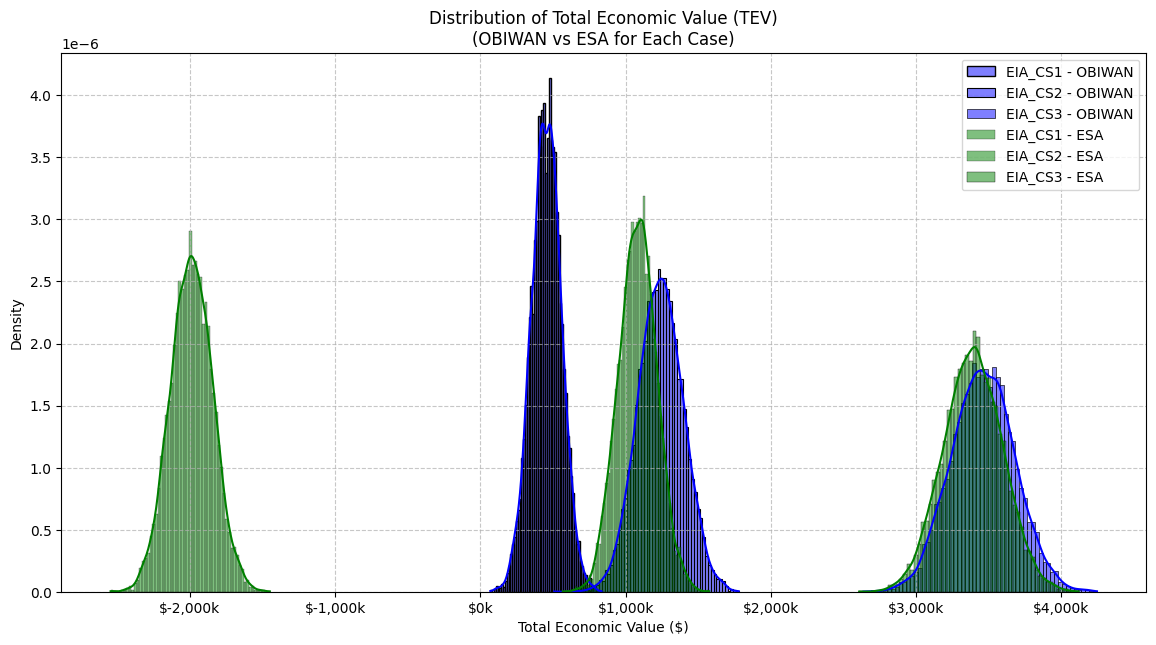

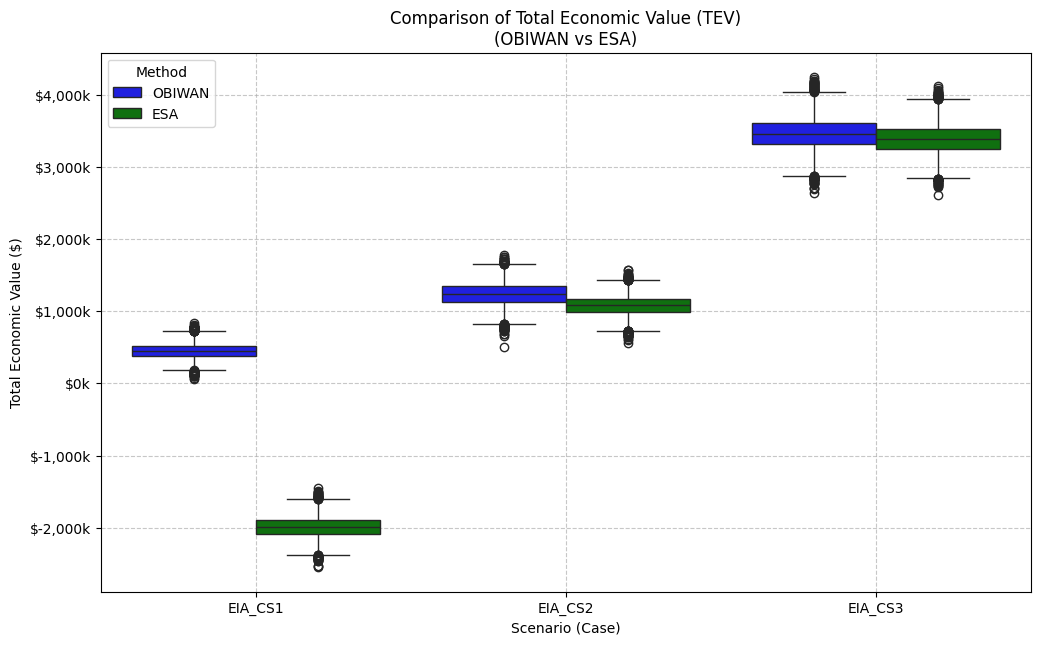

In [4]:
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# --- Collect full simulation outputs instead of just summaries ---
sim_results = []

for _, row in df.iterrows():
    case_name = row["Source"]
    method = row["Method"]

    # Copy base parameters and replace V_t + pvc_per_acre
    case_params = base_cases[case_name].copy()
    case_params["V_t"] = (row["agb_per_acre"], row["std_agb_per_acre"])
    case_params["pvc_per_acre"] = (row["pvc_per_acre_mean"], row["pvc_per_acre_std"])

    acres = case_acres[case_name]

    # Run simulation
    results = calculate_tev(case_params, acres, num_simulations)

    # Store full results for plotting
    sim_results.append({
        "Case": case_name,
        "Method": method,
        "TEV": results
    })

# --- Visualization ---

# Histograms for each Case × Method
plt.figure(figsize=(14, 7))

colors = {"OBIWAN": "blue", "ESA": "green"}
for entry in sim_results:
    sns.histplot(entry["TEV"],
                 kde=True,
                 color=colors[entry["Method"]],
                 label=f'{entry["Case"]} - {entry["Method"]}',
                 stat='density', alpha=0.5)

plt.title('Distribution of Total Economic Value (TEV)\n(OBIWAN vs ESA for Each Case)')
plt.xlabel('Total Economic Value ($)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show in thousands
formatter = ticker.FuncFormatter(lambda x, pos: f'${x/1000:,.0f}k')
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

# --- Boxplots for comparison ---
plt.figure(figsize=(12, 7))

# Convert to long DataFrame for seaborn
plot_data = []
for entry in sim_results:
    for val in entry["TEV"]:
        plot_data.append({"Case": entry["Case"], "Method": entry["Method"], "TEV": val})

plot_df = pd.DataFrame(plot_data)

sns.boxplot(data=plot_df, x="Case", y="TEV", hue="Method", palette=colors)

plt.title('Comparison of Total Economic Value (TEV)\n(OBIWAN vs ESA)')
plt.xlabel('Scenario (Case)')
plt.ylabel('Total Economic Value ($)')
plt.grid(True, linestyle='--', alpha=0.7)

# Format y-axis to show in thousands
formatter = ticker.FuncFormatter(lambda x, pos: f'${x/1000:,.0f}k')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()
